# Session-Based Recommendation Analysis

This notebook analyzes the rental product data to prepare for a session-based next-item prediction task.
We will:
1. Load the raw hits and visits data.
2. Reconstruct user sessions.
3. Filter for product interactions.
4. Prepare the data for a sequential model (like GRU4Rec or SASRec).

## 1. Load Data
We'll load a sample of the data to understand the structure. The files are large, so we'll read the first 100,000 rows for this analysis.

In [199]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [200]:
# Load ALL hits and visits
# We use low_memory=False to handle mixed types in some columns without warnings
hits_df = pd.read_csv('data/metrika_hits.csv', low_memory=False)
visits_df = pd.read_csv('data/metrika_visits.csv', low_memory=False)

print(f"Hits shape: {hits_df.shape}")
print(f"Visits shape: {visits_df.shape}")

display(hits_df.head(3))
display(visits_df.head(3))

Hits shape: (1721596, 40)
Visits shape: (323241, 26)


,project_id,watch_id,date_time,client_id,counter_user_id_hash,ip_address,region_country,region_city,page_view_id,url,page_type,slug,cart_id,order_number,exists_in_cart_table,artificial,is_page_view,not_bounce,ecommerce,link,download,params,goals_id,last_traffic_source,last_search_engine_root,last_search_engine,last_adv_engine,last_social_network,last_social_network_profile,recommendation_system,messenger,device_category,mobile_phone,mobile_phone_model,operating_system_root,operating_system,browser,browser_major_version,screen_width,screen_height
0,1,6973243044410425541,2021-11-24T00:06:51,1634151122478355093,18267426820867536905,109.252.139.xxx,Russia,Moscow,366695459,https://oldsite.info/igrovoy-derevyannyy-stoli...,PRODUCT,igrovoy-derevyannyy-stolik-elc-bolshoy,NaN,NaN,False,0,1,0,NaN,0,0,NaN,[],organic,yandex,yandex_images,NaN,NaN,NaN,NaN,NaN,2,xiaomi,MI 11,android,android_11,chromemobile,96,412,915
1,1,6973278612329332737,2021-11-24T00:09:06,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,572475715,https://oldsite.info/?fbclid=PAAabmh91Sd00ZtFJ...,MAIN,NaN,NaN,NaN,False,0,1,0,NaN,0,0,NaN,[],social,NaN,NaN,NaN,instagram,NaN,NaN,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760
2,1,6973278677122940929,2021-11-24T00:09:07,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,572475715,https://oldsite.info/?fbclid=PAAabmh91Sd00ZtFJ...,MAIN,NaN,NaN,NaN,False,1,1,0,NaN,0,0,NaN,[],social,NaN,NaN,NaN,instagram,NaN,NaN,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760


,project_id,visit_id,date_time,is_new_user,client_id,counter_user_id_hash,ip_address,region_country,region_city,watch_ids,traffic_source,adv_engine,search_engine_root,search_engine,social_network,recommendation_system,messenger,device_category,mobile_phone,mobile_phone_model,operating_system_root,operating_system,browser,browser_major_version,screen_width,screen_height
0,1,6973243044410425541,2021-11-24T00:06:51,1,1634151122478355093,18267426820867536905,109.252.139.xxx,Russia,Moscow,"[""6973243044410425541""]",organic,ya_undefined,yandex,yandex_images,NaN,NaN,NaN,2,xiaomi,MI 11,android,android_11,chromemobile,96,412,915
1,1,6973278612329332737,2021-11-24T00:09:06,1,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,"[""6973278612329332737"",""6973278677122940929"",""...",social,ya_undefined,NaN,NaN,instagram,NaN,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760
2,1,6973290657811267695,2021-11-24T00:09:52,0,1576773326761256435,14068678113715277257,178.66.158.xxx,Russia,Saint Petersburg,"[""6973290657811267695"",""6973290679046504606"",""...",referral,ya_undefined,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,gnu_linux,linux,chrome,95,1920,1080


## 2. Reconstruct Sessions
The `metrika_visits.csv` file contains a `watch_ids` column which is a list of `watch_id`s from `metrika_hits.csv` that belong to the same session.
We need to:
1. Parse the `watch_ids` string into a list.
2. Explode the `visits_df` so each row is a single hit in a session.
3. Join with `hits_df` to get the product information for each hit.

In [201]:
# Parse watch_ids
import ast

def parse_watch_ids(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

visits_df['watch_ids_list'] = visits_df['watch_ids'].apply(parse_watch_ids)

# Explode to get one row per hit in the session
session_hits = visits_df.explode('watch_ids_list').rename(columns={'watch_ids_list': 'watch_id'})

# Convert watch_id to string to ensure matching types
session_hits['watch_id'] = session_hits['watch_id'].astype(str)
hits_df['watch_id'] = hits_df['watch_id'].astype(str)

# Merge with hits to get product info
# We use inner join to keep only hits where we have details
full_session_data = session_hits.merge(hits_df, on='watch_id', how='inner')

print(f"Merged data shape: {full_session_data.shape}")
full_session_data.head()

Merged data shape: (1499141, 66)


,project_id_x,visit_id,date_time_x,is_new_user,client_id_x,counter_user_id_hash_x,ip_address_x,region_country_x,region_city_x,watch_ids,traffic_source,adv_engine,search_engine_root,search_engine,social_network,recommendation_system_x,messenger_x,device_category_x,mobile_phone_x,mobile_phone_model_x,operating_system_root_x,operating_system_x,browser_x,browser_major_version_x,screen_width_x,screen_height_x,watch_id,project_id_y,date_time_y,client_id_y,counter_user_id_hash_y,ip_address_y,region_country_y,region_city_y,page_view_id,url,page_type,slug,cart_id,order_number,exists_in_cart_table,artificial,is_page_view,not_bounce,ecommerce,link,download,params,goals_id,last_traffic_source,last_search_engine_root,last_search_engine,last_adv_engine,last_social_network,last_social_network_profile,recommendation_system_y,messenger_y,device_category_y,mobile_phone_y,mobile_phone_model_y,operating_system_root_y,operating_system_y,browser_y,browser_major_version_y,screen_width_y,screen_height_y
0,1,6973243044410425541,2021-11-24T00:06:51,1,1634151122478355093,18267426820867536905,109.252.139.xxx,Russia,Moscow,"[""6973243044410425541""]",organic,ya_undefined,yandex,yandex_images,NaN,NaN,NaN,2,xiaomi,MI 11,android,android_11,chromemobile,96,412,915,6973243044410425541,1,2021-11-24T00:06:51,1634151122478355093,18267426820867536905,109.252.139.xxx,Russia,Moscow,366695459,https://oldsite.info/igrovoy-derevyannyy-stoli...,PRODUCT,igrovoy-derevyannyy-stolik-elc-bolshoy,NaN,NaN,False,0,1,0,NaN,0,0,NaN,[],organic,yandex,yandex_images,NaN,NaN,NaN,NaN,NaN,2,xiaomi,MI 11,android,android_11,chromemobile,96,412,915
1,1,6973278612329332737,2021-11-24T00:09:06,1,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,"[""6973278612329332737"",""6973278677122940929"",""...",social,ya_undefined,NaN,NaN,instagram,NaN,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760,6973278612329332737,1,2021-11-24T00:09:06,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,572475715,https://oldsite.info/?fbclid=PAAabmh91Sd00ZtFJ...,MAIN,NaN,NaN,NaN,False,0,1,0,NaN,0,0,NaN,[],social,NaN,NaN,NaN,instagram,NaN,NaN,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760
2,1,6973278612329332737,2021-11-24T00:09:06,1,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,"[""6973278612329332737"",""6973278677122940929"",""...",social,ya_undefined,NaN,NaN,instagram,NaN,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760,6973278677122940929,1,2021-11-24T00:09:07,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,572475715,https://oldsite.info/?fbclid=PAAabmh91Sd00ZtFJ...,MAIN,NaN,NaN,NaN,False,1,1,0,NaN,0,0,NaN,[],social,NaN,NaN,NaN,instagram,NaN,NaN,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760
3,1,6973278612329332737,2021-11-24T00:09:06,1,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,"[""6973278612329332737"",""6973278677122940929"",""...",social,ya_undefined,NaN,NaN,instagram,NaN,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760,6973291042986787085,1,2021-11-24T00:09:54,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,572475715,https://oldsite.info/page/delivery,INFO,delivery,NaN,NaN,False,1,1,0,NaN,0,0,NaN,[],internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760
4,1,6973278612329332737,2021-11-24T00:09:06,1,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,"[""6973278612329332737"",""6973278677122940929"",""...",social,ya_undefined,NaN,NaN,instagram,NaN,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760,6973295444289650874,1,2021-11-24T00:10:11,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,572475715,https://oldsite.info/?fbclid=PAAabmh91Sd00ZtFJ...,MAIN,NaN,NaN,NaN,False,1,1,0,NaN,0,0,NaN,[],internal,NaN,NaN,NaN,NaN,NaN,NaN,

## 3. Filter for Product Interactions
We are interested in predicting the next *product* page. So we filter for `page_type == 'PRODUCT'`.
We also need to sort the interactions within each session by time.

In [202]:
# Filter for products
product_interactions = full_session_data[full_session_data['page_type'] == 'PRODUCT'].copy()

# Sort by time
# Use format='mixed' to handle inconsistent datetime formats (e.g. missing seconds)
product_interactions['date_time_x'] = pd.to_datetime(product_interactions['date_time_x'], format='mixed')
product_interactions = product_interactions.sort_values(['visit_id', 'date_time_x'])

# Group by session to get sequences
session_sequences = product_interactions.groupby('visit_id')['url'].apply(list).reset_index()

# Filter out sessions with only 1 item (nothing to predict)
session_sequences = session_sequences[session_sequences['url'].apply(len) > 1]

print(f"Number of valid product sessions: {len(session_sequences)}")
session_sequences.head()

Number of valid product sessions: 86970


,visit_id,url
2,714740689010850,"[https://oldsite.info/piratskiy-korabl-elc, ht..."
4,888778575315222,[https://oldsite.info/kolyaska-progulochnaya-s...
6,1772575692947650,[https://oldsite.info/elektronnye-kacheli-mama...
8,2716922663403638,"[https://oldsite.info/shezlong-jetem-relax, ht..."
9,2731618072002643,"[https://oldsite.info/avtokreslo-sparco-f500k,..."


## 3.6 Sequence Statistics
Let's look at the distribution of session lengths to decide on a padding length.

In [203]:
# Load mapping files
old_products = pd.read_csv('data/old_site_products.csv', usecols=['id', 'slug'])
old_to_new = pd.read_csv('data/old_site_new_site_products.csv')
new_products = pd.read_csv('data/new_site_products.csv', usecols=['id', 'slug'])

# Create Old Slug -> Old ID map
old_slug_map = dict(zip(old_products['slug'], old_products['id']))

# Create Old ID -> New ID map
old_id_to_new_id_map = dict(zip(old_to_new['old_site_id'], old_to_new['new_site_id']))

# Create New Slug -> New ID map
new_slug_map = dict(zip(new_products['slug'], new_products['id']))

# Unified Map Function
def get_product_id(slug):
    # Ensure slug is a string
    if not isinstance(slug, str):
        return None
        
    # Try direct new site map
    if slug in new_slug_map:
        return new_slug_map[slug]
    
    # Try old site path: Slug -> Old ID -> New ID
    if slug in old_slug_map:
        old_id = old_slug_map[slug]
        if old_id in old_id_to_new_id_map:
            return old_id_to_new_id_map[old_id]
            
    return None

# Apply mapping
# We apply this to the exploded 'full_session_data' before grouping, or to the sequences.
# Let's apply to 'product_interactions' dataframe from step 3.

product_interactions['product_id'] = product_interactions['slug'].apply(get_product_id)

# Drop interactions where we couldn't find a product ID
valid_interactions = product_interactions.dropna(subset=['product_id'])
valid_interactions['product_id'] = valid_interactions['product_id'].astype(int)

print(f"Original interactions: {len(product_interactions)}")
print(f"Mapped interactions: {len(valid_interactions)}")

# Re-group into sequences with IDs
final_sequences = valid_interactions.sort_values(['visit_id', 'date_time_x']).groupby('visit_id')['product_id'].apply(list).reset_index()
final_sequences = final_sequences[final_sequences['product_id'].apply(len) > 1]

print(f"Final valid sessions: {len(final_sequences)}")
final_sequences.head()

/var/folders/1z/csflksrn5b92jlcgb8lgbbfh0000gp/T/ipykernel_84288/3368941403.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_interactions['product_id'] = valid_interactions['product_id'].astype(int)


Original interactions: 408562
Mapped interactions: 331689
Final valid sessions: 73420
Final valid sessions: 73420


,visit_id,product_id
1,714740689010850,"[495513634, 495513634, 495513634]"
3,888778575315222,"[495400631, 495400631]"
5,1772575692947650,"[463480691, 463480231]"
7,2731618072002643,"[495253324, 495253324]"
8,2916239911157990,"[495519137, 495519137, 495519137]"


## 4. Data Preparation for PyTorch
We need to:
1.  Map Product IDs to integer indices (0 to N-1).
2.  Create `(input, target)` pairs.
    *   Input: `[Item1, Item2]`
    *   Target: `Item3`
3.  Split into Train/Validation.

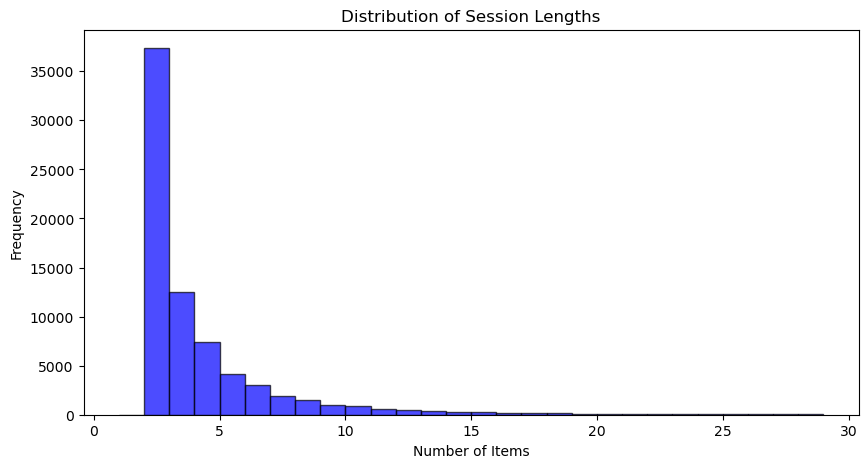

Average length: 3.89
95th percentile: 10.0


In [204]:
# Calculate session lengths
session_lengths = final_sequences['product_id'].apply(len)

plt.figure(figsize=(10, 5))
plt.hist(session_lengths, bins=range(1, 30), alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Session Lengths')
plt.xlabel('Number of Items')
plt.ylabel('Frequency')
plt.show()

print(f"Average length: {session_lengths.mean():.2f}")
print(f"95th percentile: {session_lengths.quantile(0.95)}")

## 5. Model Definition (GRU)
We'll use a simple GRU model:
- **Embedding Layer**: Converts item indices to dense vectors.
- **GRU Layer**: Processes the sequence.
- **Linear Head**: Predicts the next item.

In [205]:
from sklearn.model_selection import train_test_split

# 1. Create Item Map
all_product_ids = set([p for seq in final_sequences['product_id'] for p in seq])
item_to_idx = {p_id: idx + 1 for idx, p_id in enumerate(all_product_ids)} # 0 is reserved for padding
idx_to_item = {idx: p_id for p_id, idx in item_to_idx.items()}
vocab_size = len(item_to_idx) + 1

print(f"Vocabulary size: {vocab_size}")

# 2. Create Sequences
# We'll use a sliding window or just take the last N-1 items to predict the Nth.
# For simplicity in this baseline, let's generate multiple training samples from one session.
# Session: [A, B, C, D]
# Sample 1: [A] -> B
# Sample 2: [A, B] -> C
# Sample 3: [A, B, C] -> D

train_data = []
targets = []

MAX_LEN = 20 # Based on EDA (likely sufficient)

for seq in final_sequences['product_id']:
    # Convert to indices
    idx_seq = [item_to_idx[p] for p in seq]
    
    # Generate sub-sequences
    for i in range(1, len(idx_seq)):
        input_seq = idx_seq[:i]
        target = idx_seq[i]
        
        # Pad/Truncate
        if len(input_seq) > MAX_LEN:
            input_seq = input_seq[-MAX_LEN:]
        else:
            input_seq = [0] * (MAX_LEN - len(input_seq)) + input_seq
            
        train_data.append(input_seq)
        targets.append(target)

X = np.array(train_data)
y = np.array(targets)

print(f"Training samples: {X.shape}")

# 3. Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Vocabulary size: 587
Training samples: (212272, 20)
Training samples: (212272, 20)


## 6. Training Loop
We'll train for a few epochs and monitor validation accuracy (Recall@1 essentially).

In [206]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class RentalDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class GRURecommender(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        # x: [batch, seq_len]
        embedded = self.embedding(x) # [batch, seq_len, emb_dim]
        output, hidden = self.gru(embedded) # output: [batch, seq_len, hidden]
        
        # We only care about the last hidden state for the next item prediction
        last_output = output[:, -1, :] # [batch, hidden]
        logits = self.fc(last_output) # [batch, vocab_size]
        return logits

# Hyperparameters
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
BATCH_SIZE = 512     # Reduced from 1024 for more updates
LR = 0.001
WEIGHT_DECAY = 1e-4   # Removed L2 for now

# Data Loaders
train_dataset = RentalDataset(X_train, y_train)
val_dataset = RentalDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f"Using device: {device}")

model = GRURecommender(vocab_size, EMBEDDING_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

Using device: mps


In [207]:
# Training Loop with Early Stopping and Recall@6
print("Starting training...")

# Hyperparameters for Early Stopping
EPOCHS = 50
MIN_DELTA = 0.001
PATIENCE = 3

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_train_loss = total_loss / len(train_loader)
    
    # Validation
    model.eval()
    correct_1 = 0
    correct_6 = 0 # Track Recall@6 (since we submit 6 items)
    total = 0
    val_loss = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            val_loss += loss.item()
            
            # Top-1
            predictions = torch.argmax(logits, dim=1)
            correct_1 += (predictions == batch_y).sum().item()
            
            # Top-6
            top_6 = torch.topk(logits, 6, dim=1).indices
            # Check if target is in top 6
            # batch_y: [batch] -> [batch, 1]
            # top_6: [batch, 6]
            # (top_6 == batch_y.unsqueeze(1)): [batch, 6] boolean
            # .sum(dim=1): [batch] (1 if found, 0 if not)
            hits = (top_6 == batch_y.unsqueeze(1)).sum(dim=1)
            correct_6 += hits.sum().item()
            
            total += batch_y.size(0)
            
    avg_val_loss = val_loss / len(val_loader)
    val_acc_1 = correct_1 / total
    val_acc_6 = correct_6 / total
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | R@1: {val_acc_1:.4f} | R@6: {val_acc_6:.4f}")
    
    # Early Stopping
    if avg_val_loss < (best_val_loss - MIN_DELTA):
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"  No improvement for {patience_counter} epochs")
        
    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

print("Training complete!")

Starting training...
Epoch 1/50 | Loss: 3.6590 | Val Loss: 3.0674 | R@1: 0.3644 | R@6: 0.6501
Epoch 2/50 | Loss: 2.9605 | Val Loss: 2.9585 | R@1: 0.3689 | R@6: 0.6667
Epoch 3/50 | Loss: 2.8480 | Val Loss: 2.9269 | R@1: 0.3694 | R@6: 0.6718
Epoch 4/50 | Loss: 2.7769 | Val Loss: 2.9197 | R@1: 0.3711 | R@6: 0.6736
Epoch 5/50 | Loss: 2.7158 | Val Loss: 2.9101 | R@1: 0.3708 | R@6: 0.6743
Epoch 6/50 | Loss: 2.6586 | Val Loss: 2.9188 | R@1: 0.3724 | R@6: 0.6742
  No improvement for 1 epochs
Epoch 7/50 | Loss: 2.6035 | Val Loss: 2.9261 | R@1: 0.3710 | R@6: 0.6733
  No improvement for 2 epochs
Epoch 8/50 | Loss: 2.5491 | Val Loss: 2.9369 | R@1: 0.3746 | R@6: 0.6731
  No improvement for 3 epochs
Early stopping triggered.
Training complete!


In [ ]:
# 7. Generate Submission with Contextual Fallback
print("Generating submission...")

# 1. Calculate Global Popularity
all_train_items = [item for seq in final_sequences['product_id'] for item in seq]
from collections import Counter
global_counts = Counter(all_train_items)
global_top_popular = [item for item, count in global_counts.most_common(6)]
print(f"Global popular: {global_top_popular}")

# 2. Calculate Contextual Popularity (by Traffic Source)
# Merge sequences with visit info to get traffic source
train_visits_info = visits_df[['visit_id', 'traffic_source']].drop_duplicates('visit_id')
train_seq_with_source = final_sequences.merge(train_visits_info, on='visit_id', how='inner')

source_popular_map = {}
unique_sources = train_seq_with_source['traffic_source'].unique()

for source in unique_sources:
    source_seqs = train_seq_with_source[train_seq_with_source['traffic_source'] == source]['product_id']
    source_items = [item for seq in source_seqs for item in seq]
    source_counts = Counter(source_items)
    source_popular_map[source] = [item for item, count in source_counts.most_common(6)]

print(f"Computed popularity for sources: {list(source_popular_map.keys())}")

# 3. Load Test Data
test_hits = pd.read_csv('data/metrika_hits_test.csv', low_memory=False)
test_visits = pd.read_csv('data/metrika_visits_test.csv', low_memory=False)

# 4. Process Test Data
test_visits['watch_ids_list'] = test_visits['watch_ids'].apply(parse_watch_ids)
test_session_hits = test_visits.explode('watch_ids_list').rename(columns={'watch_ids_list': 'watch_id'})
test_session_hits['watch_id'] = test_session_hits['watch_id'].astype(str)
test_hits['watch_id'] = test_hits['watch_id'].astype(str)

test_full_data = test_session_hits.merge(test_hits, on='watch_id', how='inner')

# Filter and Sort
test_interactions = test_full_data[test_full_data['page_type'] == 'PRODUCT'].copy()
test_interactions['date_time_x'] = pd.to_datetime(test_interactions['date_time_x'], format='mixed')
test_interactions = test_interactions.sort_values(['visit_id', 'date_time_x'])

# Map IDs
test_interactions['product_id'] = test_interactions['slug'].apply(get_product_id)
test_valid_interactions = test_interactions.dropna(subset=['product_id'])
test_valid_interactions['product_id'] = test_valid_interactions['product_id'].astype(int)

# Group
test_sequences = test_valid_interactions.sort_values(['visit_id', 'date_time_x']).groupby('visit_id')['product_id'].apply(list)

# 5. Generate Predictions
submission_rows = []
all_test_visits = test_visits[['visit_id', 'traffic_source']].drop_duplicates('visit_id')

model.eval()

for _, row in all_test_visits.iterrows():
    visit_id = row['visit_id']
    source = row['traffic_source']
    
    predicted_ids = []
    
    # A. Try Model Prediction (if history exists)
    if visit_id in test_sequences:
        seq = test_sequences[visit_id]
        idx_seq = [item_to_idx.get(item, 0) for item in seq]
        
        if len(idx_seq) > 0:
            if len(idx_seq) > MAX_LEN:
                input_seq = idx_seq[-MAX_LEN:]
            else:
                input_seq = [0] * (MAX_LEN - len(idx_seq)) + idx_seq
                
            input_tensor = torch.LongTensor(input_seq).unsqueeze(0).to(device)
            
            with torch.no_grad():
                logits = model(input_tensor)
                top_k = torch.topk(logits, 20, dim=1)
                top_indices = top_k.indices[0].tolist()
                
                for idx in top_indices:
                    if idx in idx_to_item:
                        item_id = idx_to_item[idx]
                        if item_id not in predicted_ids:
                            predicted_ids.append(item_id)
                            if len(predicted_ids) == 6:
                                break
    
    # B. Fill with Contextual Popularity (Traffic Source)
    if len(predicted_ids) < 6:
        # Get popular items for this source, or global if source unknown
        fallback_items = source_popular_map.get(source, global_top_popular)
        
        for item in fallback_items:
            if item not in predicted_ids:
                predicted_ids.append(item)
                if len(predicted_ids) == 6:
                    break
                    
    # C. Fill with Global Popularity (if still needed)
    if len(predicted_ids) < 6:
        for item in global_top_popular:
            if item not in predicted_ids:
                predicted_ids.append(item)
                if len(predicted_ids) == 6:
                    break
    
    submission_rows.append({
        'visit_id': visit_id,
        'product_ids': ' '.join(map(str, predicted_ids))
    })

# 6. Save
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv('submission.csv', index=False)
print(f"Submission saved with {len(submission_df)} rows.")
submission_df.head()

Generating submission...
Top popular items (fallback): [495400314, 495400618, 463480491, 463480693, 495399966, 495400431]
Submission saved with 3891 rows.


,visit_id,product_ids
0,3705073560174199024,495400314 495400618 463480491 463480693 495399...
1,3705189088312688779,495399700 495399696 495399934 495400314 495400...
2,3705549051029618879,495400314 495400618 463480491 463480693 495399...
3,3705579516103753793,463480227 463480539 463480677 463480237 463480...
4,3705717843210797336,495400314 495400618 463480491 463480693 495399...
